In [1]:
from __future__ import print_function
import sys
import tarfile
from IPython.display import display, Image
import PIL.Image as Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
from six.moves import cPickle as pickle
import scipy.io
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
%matplotlib inline

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Extract SVHN .tar.gz files

In [2]:
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
    # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()

train_folders = maybe_extract('train.tar.gz')
test_folders = maybe_extract('test.tar.gz')

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


# Get Metadata

In [3]:
def get_attr(f,i,attr): # Get Attribute from the digitStruct.mat
    attr=f[f['digitStruct']['bbox'][i][0]][attr].value.squeeze()
    try:
        return list(np.array([f[x].value for x in attr]).squeeze())
    except:
        return list(attr.reshape(-1))

In [4]:
def get_name(f,i): # Get Name from the digitStruct.mat
    name = f[f["digitStruct"]["name"][i][0]].value.tostring()
    name = name.replace('\x00','')
    return name

In [5]:
def get_data(path):
    print(path)
    f = h5py.File(path)
    len_data = f['digitStruct']['name'].shape[0]
    images = []
    labels = []
    heights = []
    widths = []
    tops = []
    lefts = []
    
    for i in range(0,len_data):
        images.append(get_name(f, i))
        labels.append(get_attr(f, i, 'label'))
        heights.append(get_attr(f, i, 'height'))
        widths.append(get_attr(f, i, 'width'))
        tops.append(get_attr(f, i, 'top'))
        lefts.append(get_attr(f, i, 'left'))
        if (i % 2500 == 0):
            print(i,"/",len_data)
            
    print(len_data - 1, "/",len_data)
    return np.array(images),np.array(labels),np.array(heights),np.array(widths),np.array(tops),np.array(lefts)

In [6]:
    train_dataset = dict()
    train_dataset["images"],train_dataset["labels"],train_dataset["heights"],train_dataset["widths"],\
    train_dataset["tops"],train_dataset["lefts"]=get_data("train/digitStruct.mat")
    
    test_dataset = dict()   
    test_dataset["images"],test_dataset["labels"],test_dataset["heights"],test_dataset["widths"],\
    test_dataset["tops"],test_dataset["lefts"]=get_data("test/digitStruct.mat")

train/digitStruct.mat
0 / 33402
2500 / 33402
5000 / 33402
7500 / 33402
10000 / 33402
12500 / 33402
15000 / 33402
17500 / 33402
20000 / 33402
22500 / 33402
25000 / 33402
27500 / 33402
30000 / 33402
32500 / 33402
33401 / 33402
test/digitStruct.mat
0 / 13068
2500 / 13068
5000 / 13068
7500 / 13068
10000 / 13068
12500 / 13068
13067 / 13068


# Pickle Metatata

In [7]:
with open('SVHN_metadata.pickle', 'wb') as f:
    dataset = {'train_dataset':train_dataset,'test_dataset':test_dataset}
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [8]:
with open('SVHN_metadata.pickle', 'rb') as f:
    tmp = pickle.load(f)
    train_dataset = tmp['train_dataset']
    test_dataset = tmp['test_dataset']
    del tmp

# Data Exploration

## Length of labels

In [9]:
def labels_len(data):
    dict_length_count = dict()
    for label in data["labels"]:
        if len(label) not in dict_length_count:
            dict_length_count[len(label)] = 1      
        else:
            dict_length_count[len(label)] += 1
    return dict_length_count

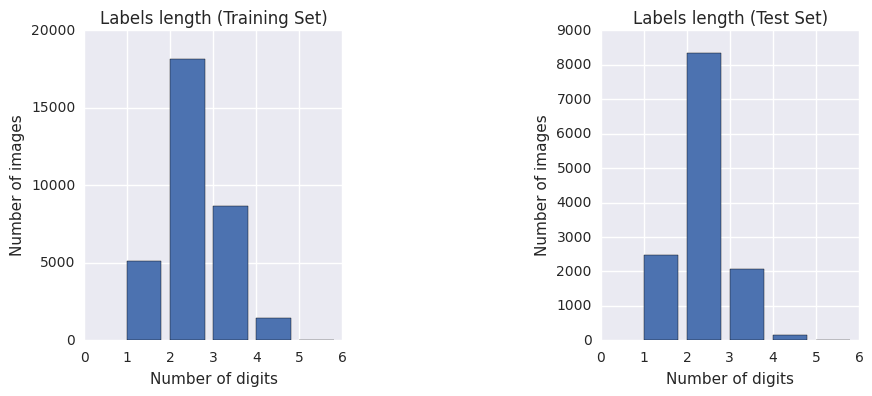

Label length in Train: {1: 5137, 2: 18130, 3: 8691, 4: 1434, 5: 9, 6: 1}
Label length in Test: {1: 2483, 2: 8356, 3: 2081, 4: 146, 5: 2}


In [10]:
train_labels_length = labels_len(train_dataset)
test_labels_length = labels_len(test_dataset)

fig = plt.figure(figsize=(10,4)) 
gs = gridspec.GridSpec(1,2)
gs.update(wspace=1)

ax1 = plt.subplot(gs[:,0])
ax1.bar(train_labels_length.keys(),train_labels_length.values())
plt.title("Labels length (Training Set)")
plt.xlabel("Number of digits")
plt.ylabel("Number of images ")
plt.xlim(0,6)

ax2 = plt.subplot(gs[:,1])
ax2.bar(test_labels_length.keys(),test_labels_length.values())
plt.title("Labels length (Test Set)")
plt.xlabel("Number of digits")
plt.ylabel("Number of images ")
plt.xlim(0,6)

plt.savefig("./imgs/hist_labels_length.png")
plt.show()

print('Label length in Train:',train_labels_length)
print('Label length in Test:',test_labels_length)

## Digit sizes (width and height) 

In [11]:
def get_bbox(data,key):
    list_value=[]
    for values in data[key]:
        for value in values:
            list_value.append(value)
    return list_value

In [12]:
list_height_train=get_bbox(train_dataset,'heights')
list_height_test=get_bbox(test_dataset,'heights')

list_width_train=get_bbox(train_dataset,'widths')
list_width_test=get_bbox(test_dataset,'widths')

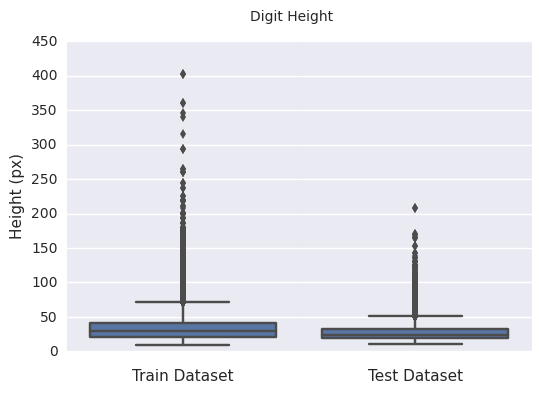

Heights in Train: (mean, median, std) = (33.86, 29.00, 18.60)
Heights in Test: (mean, median, std) = (27.96, 24.00, 13.46)


In [13]:
fig = plt.figure()
fig.suptitle("Digit Height")
gs = gridspec.GridSpec(1,2)
gs.update(wspace=0)

ax1 = fig.add_subplot(gs[:,0],)
sns.boxplot(list_height_train,ax=ax1,orient='v')
plt.ylabel('Height (px)')
plt.xlabel('Train Dataset')

ax2 = fig.add_subplot(gs[:,1],sharey=ax1)
sns.boxplot(list_height_test,ax=ax2,orient='v')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.xlabel('Test Dataset')

plt.savefig("./imgs/Digits_Height.png")
sns.plt.show()

print ('Heights in Train: (mean, median, std) = (%.2f, %.2f, %.2f)' % (np.mean(list_height_train),np.median(list_height_train),np.std(list_height_train)))                                                  
print ('Heights in Test: (mean, median, std) = (%.2f, %.2f, %.2f)' % (np.mean(list_height_test),np.median(list_height_test),np.std(list_height_test)))                                                                                                   

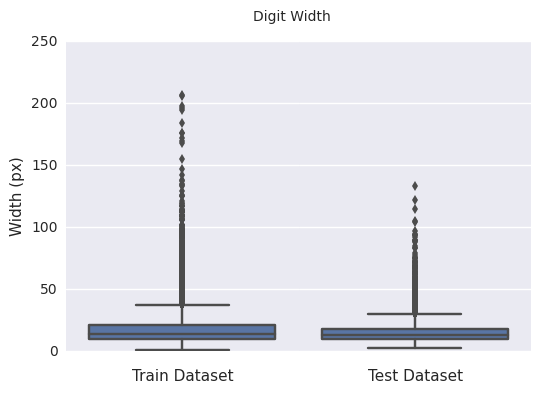

Widths in Train: (mean, median, std) = (16.65, 14.00, 10.68)
Widths in Test: (mean, median, std) = (15.52, 13.00, 8.24)


In [14]:
fig = plt.figure() 
fig.suptitle("Digit Width")
gs = gridspec.GridSpec(1,2)
gs.update(wspace=0)

ax1 = fig.add_subplot(gs[:,0],)
sns.boxplot(list_width_train,ax=ax1,orient='v')
plt.ylabel('Width (px)')
plt.xlabel('Train Dataset')

ax2 = fig.add_subplot(gs[:,1],sharey=ax1)
sns.boxplot(list_width_test,ax=ax2,orient='v')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.xlabel('Test Dataset')

plt.savefig("./imgs/Digits_Width.png")
sns.plt.show()

print ('Widths in Train: (mean, median, std) = (%.2f, %.2f, %.2f)' % (np.mean(list_width_train),np.median(list_width_train),np.std(list_width_train)))                                                  
print ('Widths in Test: (mean, median, std) = (%.2f, %.2f, %.2f)' % (np.mean(list_width_test),np.median(list_width_test),np.std(list_width_test)))                                                                                                   

# Create Dataset

In [15]:
def create_dataset(path,data):
    length=data["images"].shape[0]
    dataset = np.ndarray([length,32,32,3], dtype='float32')
    labels = np.ones([length,5], dtype=int) *10
    list_remove = []

    for i in np.arange(length):
        image_name = data['images'][i] 
        image = Image.open(os.path.join(path,image_name))
        num_digit = len(data['labels'][i])
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):
            if j < 5:
                labels[i,j] = data['labels'][i][j]
                if data['labels'][i][j] == 10: 
                    labels[i,j] = 0
            else: 
                list_remove.append(i)
                
            top[j] = data['tops'][i][j]
            left[j] = data['lefts'][i][j]
            height[j] = data['heights'][i][j]
            width[j] = data['widths'][i][j]
        
        image_top = np.amin(top)
        image_left = np.amin(left)
        image_height  = np.amax(top + height) - image_top
        image_width = np.amax(left + width) - image_left
        
        image_top = int(np.amax([np.floor(image_top - 0.2 * image_height), 0]))
        image_left = int(np.amax([np.floor(image_left - 0.2 * image_width), 0]))
        image_bottom = int(np.amin([np.ceil(image_top + 1.2 * image_height), image.size[1]]))
        image_right = int(np.amin([np.ceil(image_left + 1.2 * image_width), image.size[0]]))

        # Crop images
        dataset[i,:,:,:] = image.crop((image_left, image_top, image_right, image_bottom)).resize([32,32], Image.ANTIALIAS)
   
    for idx in reversed(list_remove):
        dataset = np.delete(dataset, idx, axis=0)
        labels = np.delete(labels, idx, axis=0)
        print('Image',idx,'has been removed.') # Remove images with more than 5 digits
    return dataset, labels

In [16]:
time train_dataset, train_labels = create_dataset("train/",train_dataset)

Image 29929 has been removed.
CPU times: user 51.7 s, sys: 6.38 s, total: 58.1 s
Wall time: 1min 10s


In [17]:
time test_dataset,test_labels = create_dataset("test/",test_dataset)

CPU times: user 27.9 s, sys: 2.96 s, total: 30.9 s
Wall time: 36.2 s


In [18]:
print('Train: ',train_dataset.shape, train_labels.shape)
print('Test: ',test_dataset.shape, test_labels.shape)

Train:  (33401, 32, 32, 3) (33401, 5)
Test:  (13068, 32, 32, 3) (13068, 5)


## Shuffle Data

In [19]:
def shuffle_data(dataset, labels):
    shuffled_idx = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[shuffled_idx,:,:,:]
    shuffled_labels = labels[shuffled_idx]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = shuffle_data(train_dataset, train_labels)

print('Train: ',train_dataset.shape, train_labels.shape)
print('Test: ',test_dataset.shape, test_labels.shape)

Train:  (33401, 32, 32, 3) (33401, 5)
Test:  (13068, 32, 32, 3) (13068, 5)


## Create Validation Set

In [20]:
def split_train_valid(data, labels, valid_ratio):
    limit = int(labels.shape[0]*valid_ratio)
    data_valid = data[:limit,:,:,:]
    labels_valid = labels[:limit]
    data_train = data[limit:,:,:,:]
    labels_train = labels[limit:]
    return data_train, labels_train, data_valid, labels_valid

In [21]:
train_dataset, train_labels, valid_dataset, valid_labels = split_train_valid(train_dataset, train_labels, 0.2)

In [22]:
print('Train: ',train_dataset.shape, train_labels.shape)
print('Test: ',test_dataset.shape, test_labels.shape)
print('Validation: ',valid_dataset.shape, valid_labels.shape)

Train:  (26721, 32, 32, 3) (26721, 5)
Test:  (13068, 32, 32, 3) (13068, 5)
Validation:  (6680, 32, 32, 3) (6680, 5)


## Show a sample of the original image

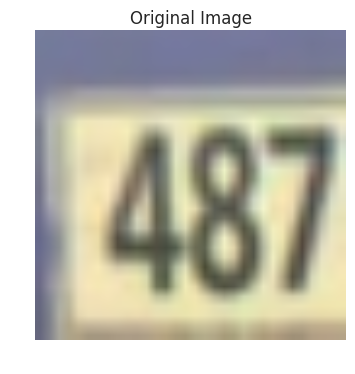

In [49]:
img=train_dataset[39,:,:,:]
plt.imshow(img)
plt.grid(False)
plt.axis('off')
plt.title('Original Image')
plt.savefig('./imgs/Original_Image.png')
plt.show()

## To GrayScale

In [50]:
def rgb2gray(data): # Similar to the rgb2gray function in MATLAB
    data = np.dot(data[...,:3], [0.299, 0.587, 0.114])
    return data

train_dataset = rgb2gray(train_dataset)
valid_dataset = rgb2gray(valid_dataset)
test_dataset = rgb2gray(test_dataset)

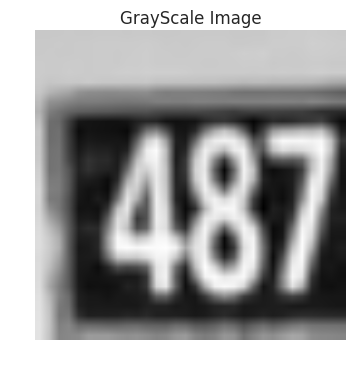

In [51]:
img = train_dataset[39,:,:]
plt.imshow(img, cmap = cm.Greys_r)
plt.axis('off')
plt.title('GrayScale Image')
plt.savefig('./imgs/GrayScale_Image.png')
plt.show()

## Normalize

In [52]:
def normalize(dataset):
    for i in range(0,dataset.shape[0]):
        dataset[i,:,:] = (dataset[i,:,:] - dataset[i,:,:].mean()) / dataset[i,:,:].std()
    return dataset

train_dataset = normalize(train_dataset)
valid_dataset = normalize(valid_dataset)
test_dataset = normalize(test_dataset)

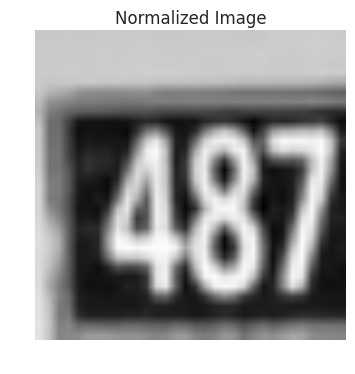

In [54]:
img = train_dataset[39,:,:]
plt.imshow(img, cmap = cm.Greys_r)
plt.axis('off')
plt.title('Normalized Image')
plt.savefig('./imgs/Normalized_Image.png')
plt.show()

## Reshape for CNN

In [55]:
image_size = 32
num_labels = 11 
num_channels = 1 # grayscale

def reshape_for_CNN(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = labels.astype(np.int32)
    return dataset, labels

train_dataset, train_labels = reshape_for_CNN(train_dataset, train_labels)
valid_dataset, valid_labels = reshape_for_CNN(valid_dataset, valid_labels)
test_dataset, test_labels = reshape_for_CNN(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (26721, 32, 32, 1) (26721, 5)
Validation set (6680, 32, 32, 1) (6680, 5)
Test set (13068, 32, 32, 1) (13068, 5)


## Pickle data

In [56]:
with open('SVHN_data.pickle', 'wb') as f:
    dataset = {'train_dataset':train_dataset,'test_dataset':test_dataset,'valid_dataset':valid_dataset,\
               'train_labels':train_labels,'test_labels':test_labels,'valid_labels':valid_labels}
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
f.close()
statinfo = os.stat('SVHN_data.pickle')
print('Size:', statinfo.st_size)

Size: 191266856
